In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = 256

index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: rec.autos
apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watch around in a seclude spot etc have my key ready to open the door so i m


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 2727


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [10]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
    pmi = np.log2(pxy / (probability[word] * probability))
    
    pmi = pmi.replace([np.inf, -np.inf], 0)
    pmi = pmi.fillna(0)
    
    dev = pmi - pmi.min()
    word_word_co[word] = dev / dev.sum()

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



word_word_co has shape (2727, 2727)


In [11]:
word_word_co.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
00,0.070043,0.000312,0.000000,0.000000,0.000000,0.0,0.0,0.002954,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.000000,0.003021,0.000000,0.000000,0.000000,0.0,0.0,0.002210,0.000284,0.00033,...,0.000490,0.000490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0098,0.000000,0.000312,0.054181,0.000000,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020359,0.000000,0.000312,0.000000,0.040777,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
031349,0.000000,0.000312,0.000000,0.000000,0.048983,0.0,0.0,0.000329,0.000284,0.00033,...,0.000557,0.000811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [12]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]

pivot_entropy = word_entropy
pivot_entropy = (pivot_entropy - pivot_entropy.mean())

word_weight = pd.DataFrame(data=gaussian(pivot_entropy), columns=[0], index=vocabulary)[0]

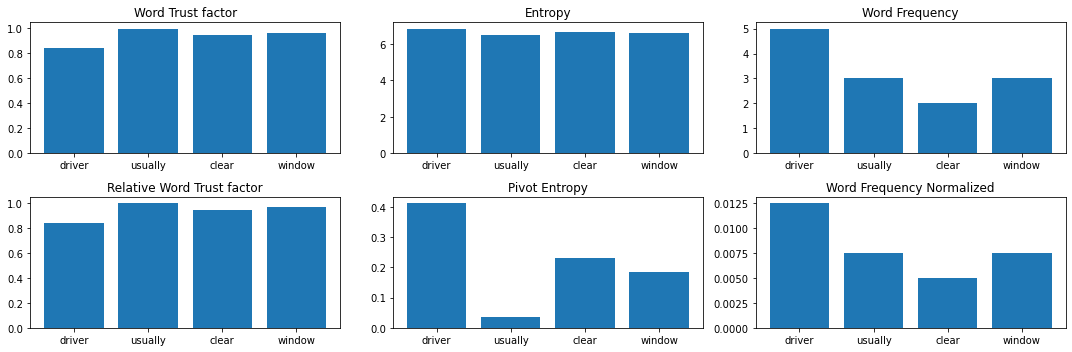

In [13]:
# words = ["israel", "the", "algorithm", "program", "and"]
words = ["driver", "usually", "clear", "window"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(231)
ax12 = fig.add_subplot(232)
ax13 = fig.add_subplot(233)
ax21 = fig.add_subplot(234)
ax22 = fig.add_subplot(235)
ax23 = fig.add_subplot(236)

ax11.set_title(f"Word Trust factor")
ax11.bar(words, word_weight[words])

ax12.set_title(f"Entropy")
ax12.bar(words, word_entropy[words])

ax13.set_title(f"Word Frequency")
ax13.bar(words, word_freq_in_doc.sum(0)[words])

word_weight = word_weight / word_weight.max()

ax21.set_title(f"Relative Word Trust factor")
ax21.bar(words, word_weight[words])

ax22.set_title(f"Pivot Entropy")
ax22.bar(words, abs(pivot_entropy)[words])

ax23.set_title(f"Word Frequency Normalized")
ax23.bar(words, (probability)[words])

plt.show()

In [14]:
word_weight.sort_values(ascending=False).head(5)

reporting     1.0
bias          1.0
propaganda    1.0
goering       1.0
press         1.0
Name: 0, dtype: float64

### Observe word_word_co ratios

In [15]:
wwc = (word_word_co * word_weight)

=== Ploting software against ['driver', 'usually', 'clear', 'window'] ===


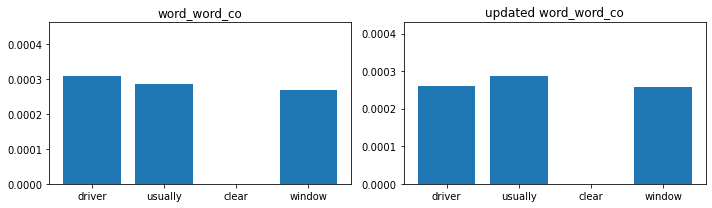

In [16]:
word = "software"

fig = plt.figure(figsize=(10,3), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

values = word_word_co.loc[word][words]
ax1.set_title(f"word_word_co")
ax1.set_ylim(0, 1.5*values.max())
ax1.bar(words, values)

values = wwc.loc[word][words]
ax2.set_title(f"updated word_word_co")
ax2.set_ylim(0, 1.5*values.max())
ax2.bar(words, values)

plt.show()

In [17]:
wwc.loc["war"].sort_values(ascending=False).head(10)

civil       0.072930
war         0.072930
currency    0.072930
coin        0.072930
various     0.034879
require     0.030262
motto       0.008162
50          0.005253
since       0.002067
didn        0.001214
Name: war, dtype: float64

In [18]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

war         0.089770
currency    0.089770
coin        0.089770
civil       0.089770
various     0.037669
require     0.031299
motto       0.008694
50          0.005601
since       0.002068
didn        0.001658
Name: war, dtype: float64

In [19]:
word_word_co = wwc.copy()

### Update word_word_co with word_word_co

In [20]:
doc_word_distr = word_doc_frequency_norm * word_weight

In [21]:
doc_index = 13
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

be         0.044444
you        0.044444
see        0.044444
to         0.044444
their      0.044444
they       0.044444
middle     0.022222
if         0.022222
them       0.022222
obvious    0.022222
Name: 13, dtype: float64

In [23]:
doc_word_distr.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['lock', 'door', 'woman', 'apparently', 'key']


### Define Latent partitions

In [61]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.mean(1), doc_word_distr.std(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2727)


In [62]:
distr_params.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
doc_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(doc_word_distr.T, base=2)), columns=[0], index=distr_params.index)[0]

# doc_weight = pd.DataFrame(data=gaussian2(doc_entropy), columns=[0], index=distr_params.index)[0]
doc_weight = pd.DataFrame(data=gaussian(doc_entropy - doc_entropy.mean()), columns=[0], index=distr_params.index)[0]

doc_weight = doc_weight / doc_weight.sum()

In [64]:
doc_index = doc_weight.argmin()
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: alt.atheism
deletion


In [65]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

deletion     1.835613e-07
zuma         0.000000e+00
execution    0.000000e+00
expensive    0.000000e+00
expel        0.000000e+00
expect       0.000000e+00
exists       0.000000e+00
exist        0.000000e+00
exhibit      0.000000e+00
exhaust      0.000000e+00
Name: 83, dtype: float64

In [66]:
doc_index = doc_weight.argmax()
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: talk.politics.mideast
hmm turk sure know how to keep track of death but they seem to lose count around 1 5 million


In [67]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

death      0.054603
count      0.054113
turk       0.054113
lose       0.054113
million    0.053394
track      0.052413
keep       0.052279
hmm        0.052081
around     0.038467
seem       0.025518
Name: 112, dtype: float64

In [68]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: talk.politics.mideast
hmm turk sure know how to keep track of death but they seem to lose count around 1 5 million


### Using Kmeans MiniBatch

In [33]:
num_of_topics = 4

In [34]:
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=distr_params.std(1))
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=doc_weight)

In [35]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [36]:
Counter(predicted_labels)

Counter({1: 159, 0: 91, 3: 113, 2: 37})

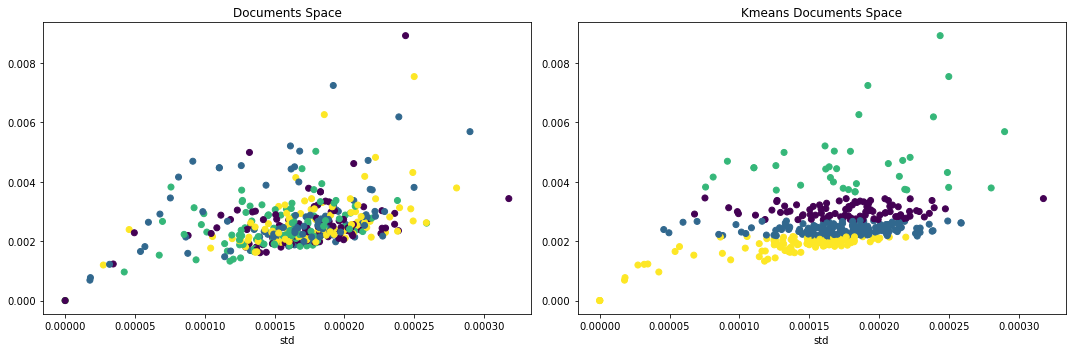

In [37]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [38]:
voc_array = np.array(vocabulary)

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [39]:
get_top(0)

Counter({'alt.atheism': 26, 'rec.autos': 24, 'sci.space': 23, 'talk.politics.mideast': 18})
must        0.004237
only        0.003751
people      0.003039
religion    0.002903
back        0.002697
name        0.002594
last        0.002511
sound       0.002418
thanks      0.002388
him         0.002347
dtype: float64


In [40]:
get_top(1)

Counter({'sci.space': 43, 'rec.autos': 42, 'talk.politics.mideast': 37, 'alt.atheism': 37})
thanks    0.001711
those     0.001684
how       0.001681
up        0.001662
tell      0.001560
system    0.001551
god       0.001506
mean      0.001498
into      0.001466
many      0.001454
dtype: float64


In [41]:
get_top(2)

Counter({'talk.politics.mideast': 18, 'sci.space': 7, 'rec.autos': 6, 'alt.atheism': 6})
life        0.016237
mr          0.013934
israel      0.013400
retard      0.009740
people      0.008598
language    0.008536
case        0.007629
hey         0.007411
most        0.007332
serdar      0.007062
dtype: float64


In [42]:
get_top(3)

Counter({'alt.atheism': 31, 'rec.autos': 28, 'talk.politics.mideast': 27, 'sci.space': 27})
re           0.001725
back         0.001614
question     0.001522
way          0.001338
well         0.001331
problem      0.001259
something    0.001256
long         0.001252
need         0.001237
look         0.001206
dtype: float64


In [43]:
## Setup

In [186]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [187]:
## Create a sampling layer

In [188]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [189]:
## Build the encoder

In [200]:
latent_dim = 2

encoder_inputs = keras.Input(shape=param_values.shape[1])

x = layers.Dense(1024, activation="relu")(encoder_inputs)
# x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
# x = layers.Dense(8, activation="relu")(x)
# x = layers.Dense(4, activation="relu")(x)


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 2727)]       0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 1024)         2793472     input_15[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 256)          262400      dense_49[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 16)           4112        dense_50[0][0]                   
____________________________________________________________________________________________

### Build the decoder

In [201]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
decoder_outputs = layers.Dense(param_values.shape[1], activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_52 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_53 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_54 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_55 (Dense)             (None, 2727)              2795175   
Total params: 3,062,743
Trainable params: 3,062,743
Non-trainable params: 0
_________________________________________________________________


### Define the VAE as a `Model` with a custom `train_step`

In [202]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= param_values.shape[1]
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
#             entropy_loss = 0
#             centers = [[-1.0, 1.0], [1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]]
            
#             for center in centers:
#                 center = tf.constant(center)
#                 pr = tf.norm(z_mean - center, ord='euclidean')**-1
#                 entropy_loss += pr * tf.math.log(pr)
                
#             entropy_loss *= -1
            
            total_loss = reconstruction_loss + kl_loss
#             total_loss = (tf.math.reduce_std(z_mean) + tf.math.reduce_std(z_log_var) +tf.math.reduce_std(z))**-1
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Train the VAE

In [204]:
# vae = VAE(encoder, decoder)
vae = keras.Model(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(param_values, epochs=30, batch_size=128)

AttributeError: 'Model' object has no attribute 'op'

### Display how the latent space clusters different digit classes

In [194]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(7, 5))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

x_train = np.expand_dims(param_values, -1).astype("float32")

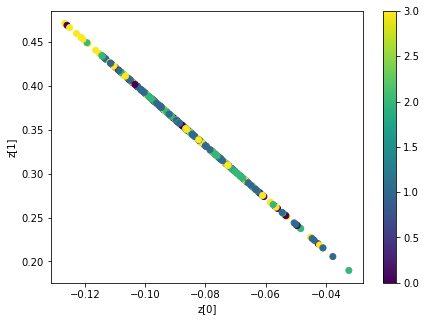

In [195]:
plot_label_clusters(encoder, decoder, x_train, label_indices)

### LDA